In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import plotters as plot
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import check_seasonality,plot_acf,plot_pacf,remove_seasonality,remove_trend,stationarity_test_adf
from darts.utils.statistics import extract_trend_and_seasonality
import os
from meteostat import Point, Hourly
import holidays
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]


list_data = os.listdir('./data')
csv_data = [n for n in list_data if n.endswith('.csv')]
for csv in sorted(csv_data):
    print(csv)

AEP_hourly.csv
COMED_hourly.csv
DAYTON_hourly.csv
DEOK_hourly.csv
DOM_hourly.csv
DUQ_hourly.csv
EKPC_hourly.csv
FE_hourly.csv
NI_hourly.csv
PJME_hourly.csv
PJMW_hourly.csv
PJM_Load_hourly.csv
pjm_hourly_est.csv


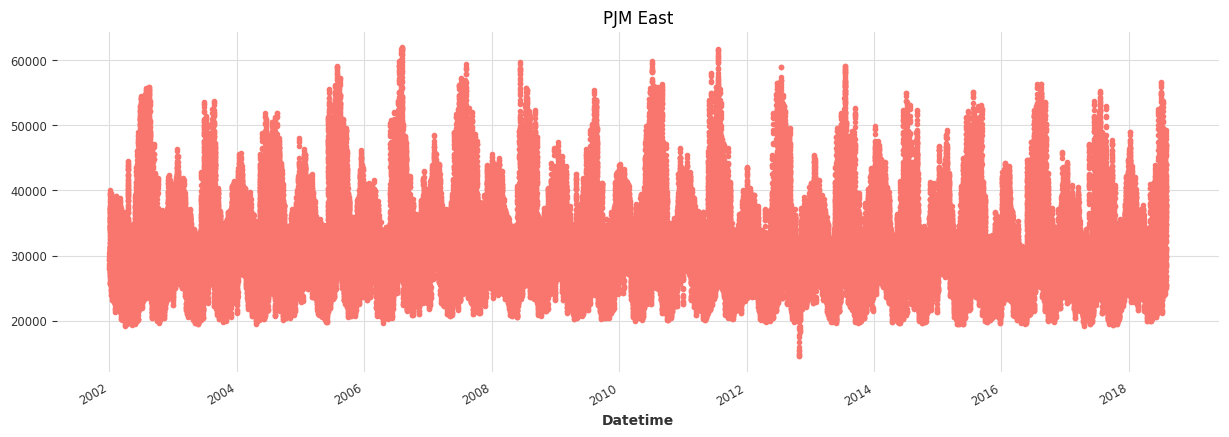

In [3]:
pjme_df = pd.read_csv('./data/PJME_hourly.csv', delimiter=',', nrows = None, parse_dates=['Datetime'])
pjme_df['Datetime'] = pd.to_datetime(pjme_df['Datetime'])
us_holidays = holidays.US()
def is_holiday(date):
    return date in us_holidays
pjme_df['is_holiday'] = pjme_df['Datetime'].apply(is_holiday)

pjme_df.set_index('Datetime', inplace=True)

_ = pjme_df['PJME_MW'].plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')


In [4]:
philly = Point(39.9526, -75.1652)

start = pjme_df.index.min()
end = pjme_df.index.max()
temp_data = Hourly(philly, start, end)
temp_data = temp_data.fetch()
pjme_df = pjme_df.merge(temp_data[['temp']], left_index=True, right_index=True, how='left')
pjme_df['is_weekend'] = pjme_df.index.dayofweek.isin([5, 6])
pjme_df['day_name'] = pjme_df.index.day_name()


def create_features(
                    df: pd.DataFrame,
                    label=None
    ) -> pd.DataFrame: 
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df.drop('date', axis=1, inplace=True)

    col = df.columns.tolist()
    
    if label:
        col.remove(label)
        return df[col], df[label]
    return df

X, y = create_features(pjme_df, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)


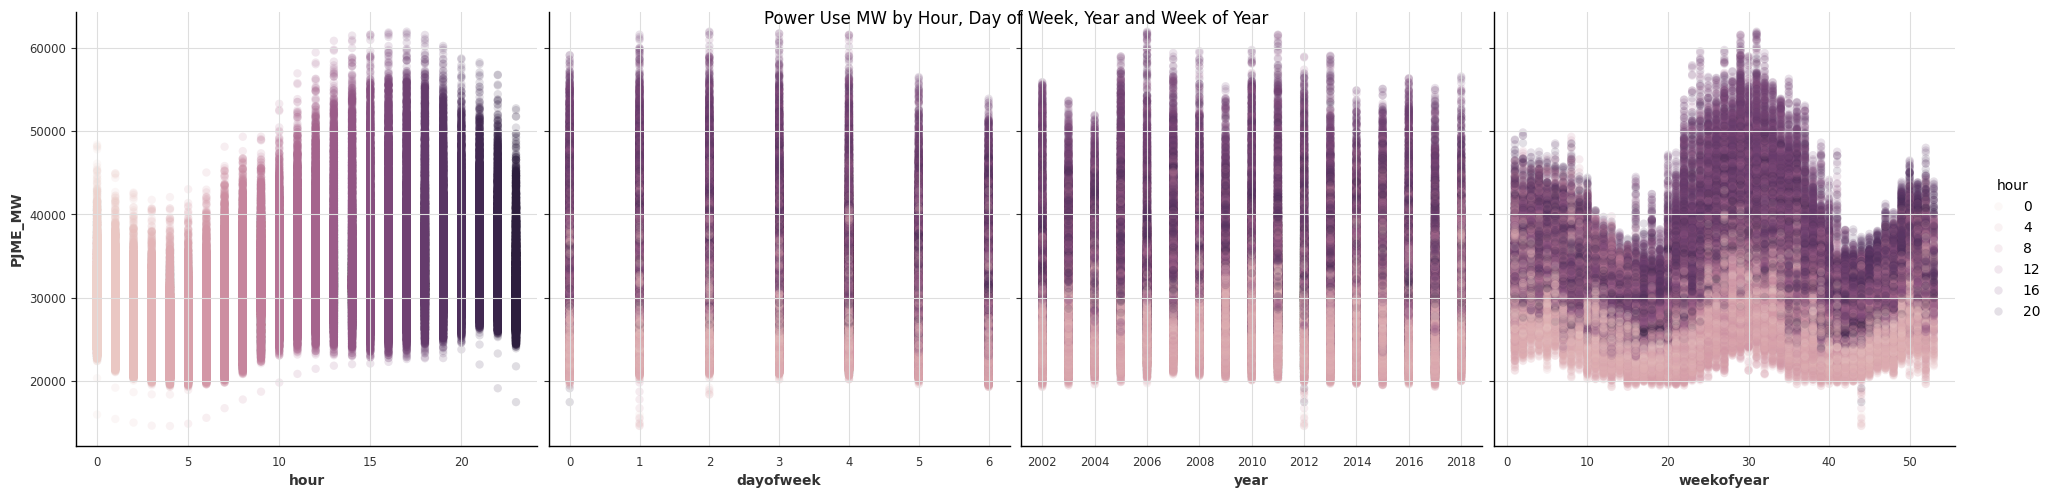

In [5]:
sns.pairplot(features_and_target.dropna(),
            hue='hour',
            x_vars=['hour','dayofweek',
                    'year','weekofyear'],
            y_vars='PJME_MW',
            height=5,
            plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()



In [6]:
def ts_train_test_split(df: pd.DataFrame | TimeSeries, split_date: datetime
    )-> tuple[pd.DataFrame, pd.DataFrame]:
    split_date = datetime(2016, 1, 1)
    train = df.loc[df.index <= split_date].copy()
    test = df.loc[df.index > split_date].copy()
    return train, test

split_date = datetime(2016, 1, 1)
pjme_train, pjme_test = ts_train_test_split(features_and_target, split_date)

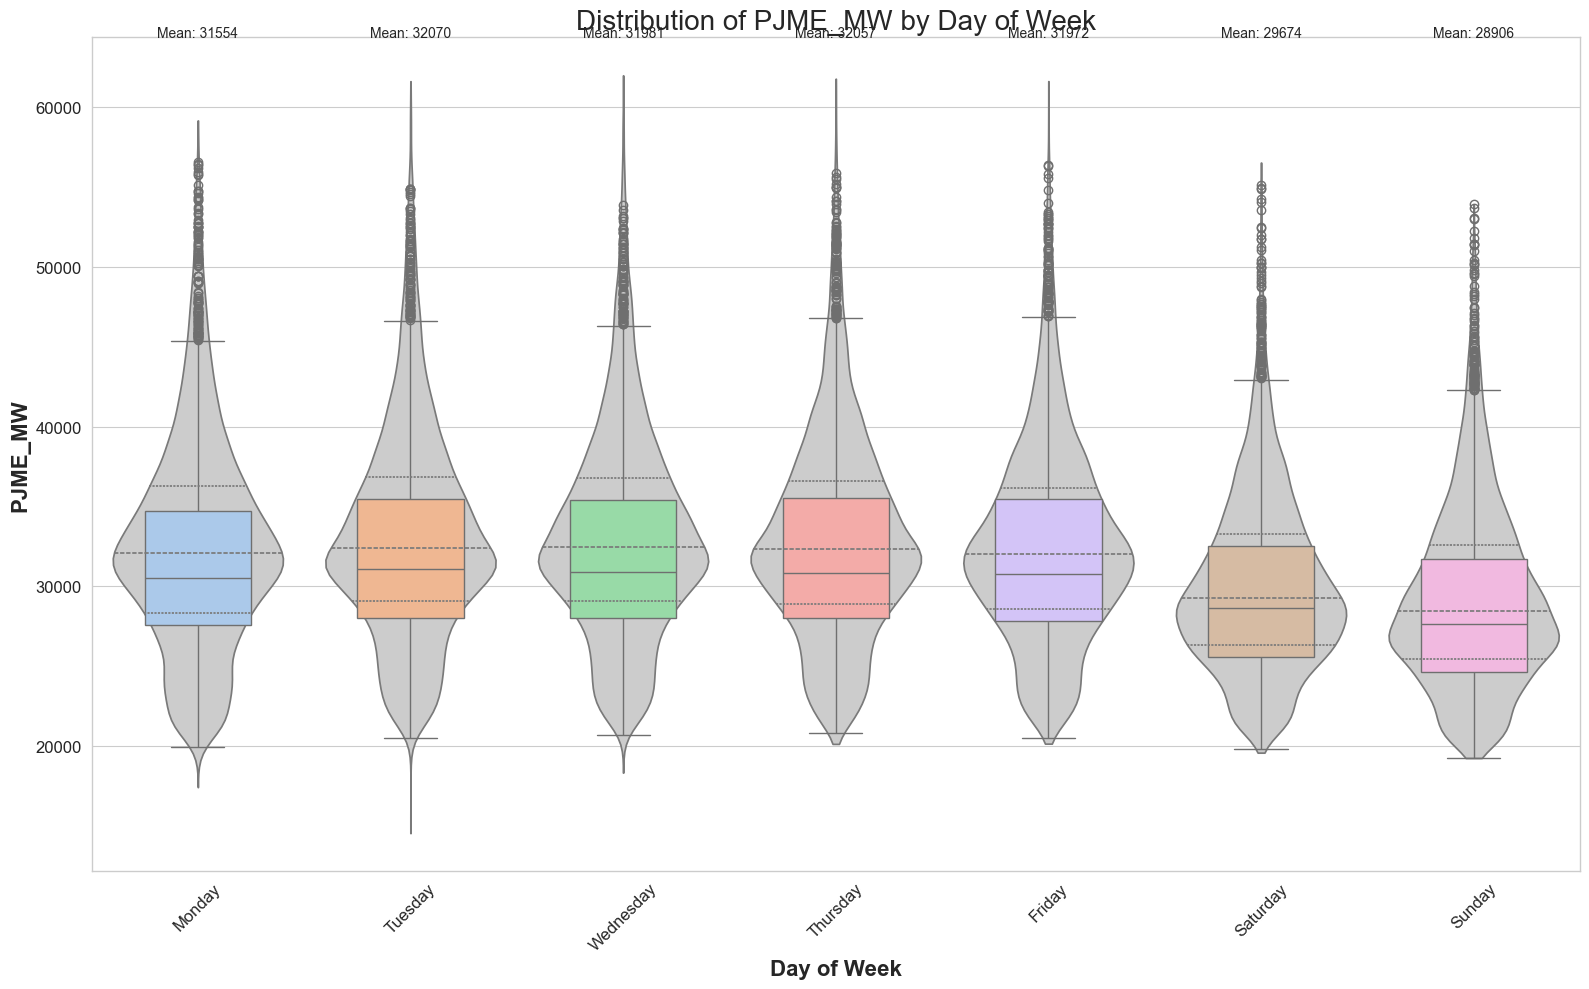

In [7]:
# Create a custom order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set the style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(16, 10))

# Create the box plot
sns.boxplot(x='day_name', y='PJME_MW', data=pjme_test, order=day_order, 
            palette='pastel', width=0.5)

# Create the violin plot
sns.violinplot(x='day_name', y='PJME_MW', data=pjme_df, order=day_order,
            scale='width', inner='quartile', cut=0, color=".8")

# Customize the plot
plt.title('Distribution of PJME_MW by Day of Week', fontsize=20)
plt.xlabel('Day of Week', fontsize=16)
plt.ylabel('PJME_MW', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add some statistics
for i, day in enumerate(day_order):
    day_data = pjme_test[pjme_test['day_name'] == day]['PJME_MW']
    mean = day_data.mean()
    plt.text(i, plt.ylim()[1], f'Mean: {mean:.0f}', 
            horizontalalignment='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
pjme_test.head()

,is_holiday,temp,is_weekend,day_name,hour,dayofweek,quarter,year,dayofyear,dayofmonth,month,weekofyear,PJME_MW
Datetime,,,,,,,,,,,,,
2016-12-31 01:00:00,False,2.2,True,Saturday,1,5,4,2016,366,31,12,52,29627.0
2016-12-31 02:00:00,False,1.7,True,Saturday,2,5,4,2016,366,31,12,52,28744.0
2016-12-31 03:00:00,False,1.7,True,Saturday,3,5,4,2016,366,31,12,52,28274.0
2016-12-31 04:00:00,False,1.7,True,Saturday,4,5,4,2016,366,31,12,52,28162.0
2016-12-31 05:00:00,False,0.0,True,Saturday,5,5,4,2016,366,31,12,52,28434.0


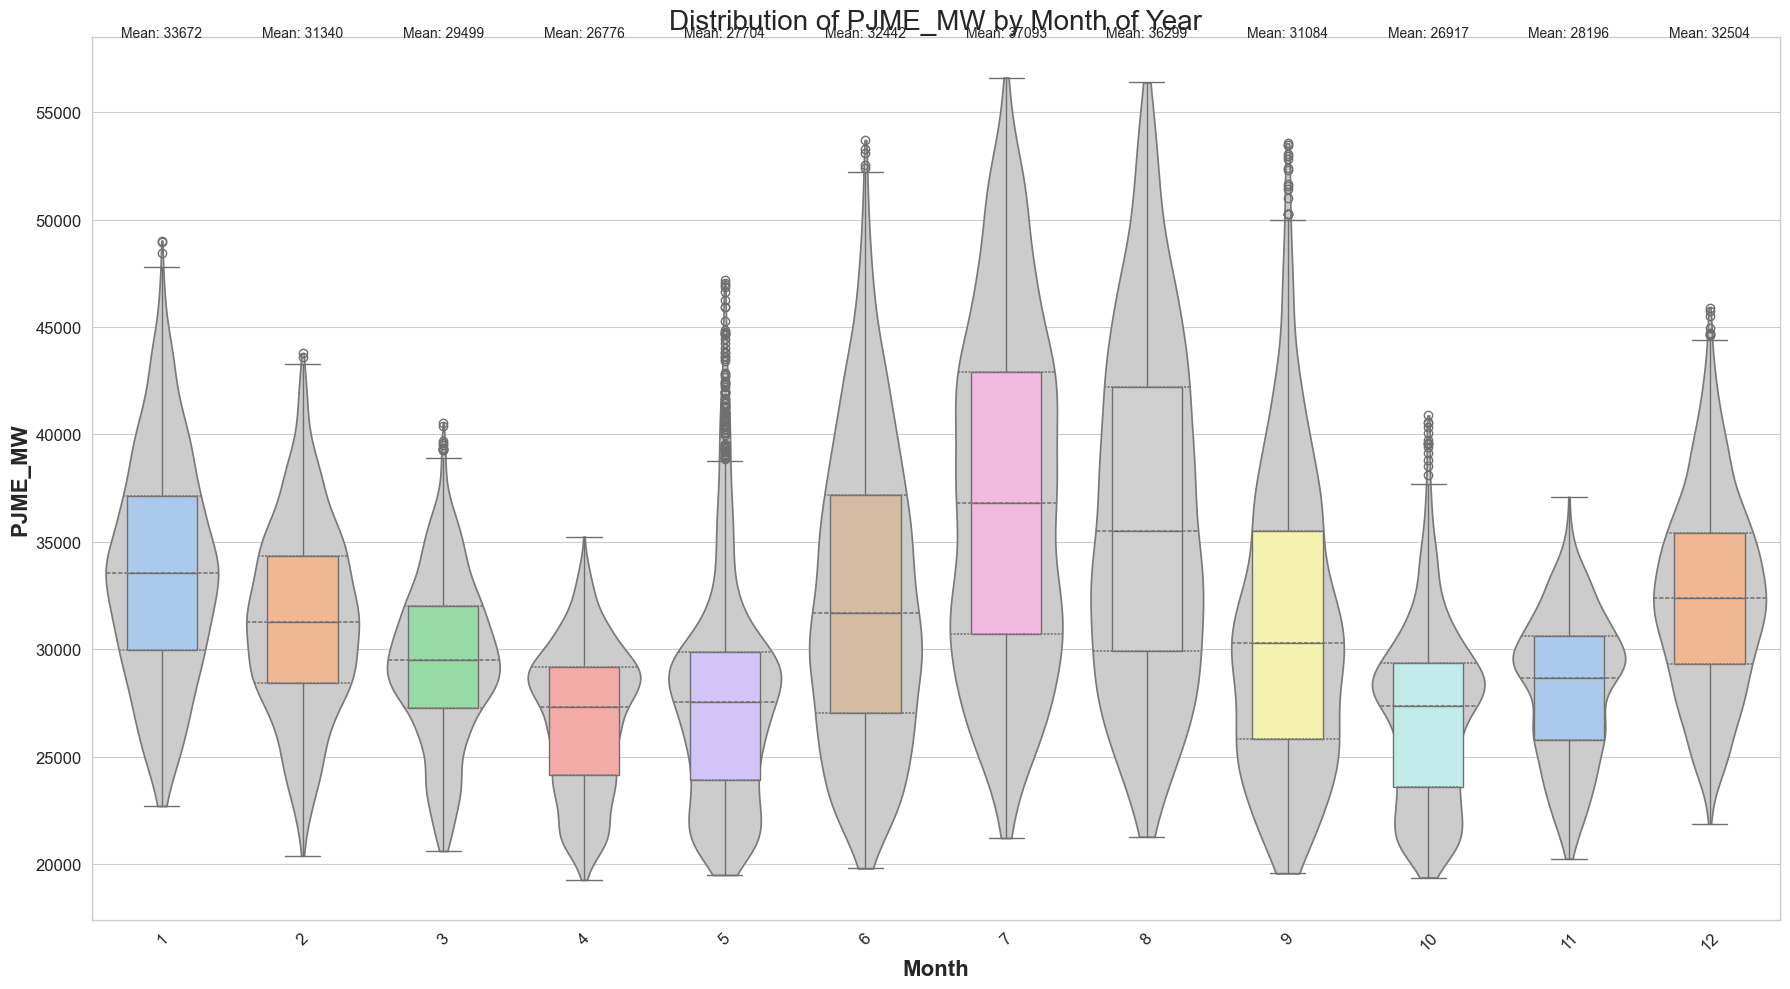

In [9]:
# Create a custom order for months of the year
month_order = [i for i in range(1, 13)]

# Set the style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(18, 10))

# Create the box plot
sns.boxplot(x='month', y='PJME_MW', data=pjme_test, order=month_order, 
            palette='pastel', width=0.5)

# Create the violin plot
sns.violinplot(x='month', y='PJME_MW', data=pjme_test, order=month_order,
            scale='width', inner='quartile', cut=0, color=".8")

# Customize the plot
plt.title('Distribution of PJME_MW by Month of Year', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('PJME_MW', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add some statistics
for i, month in enumerate(month_order):
    month_data = pjme_test[pjme_test['month'] == month]['PJME_MW']
    mean = month_data.mean()
    plt.text(i, plt.ylim()[1], f'Mean: {mean:.0f}', 
            horizontalalignment='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

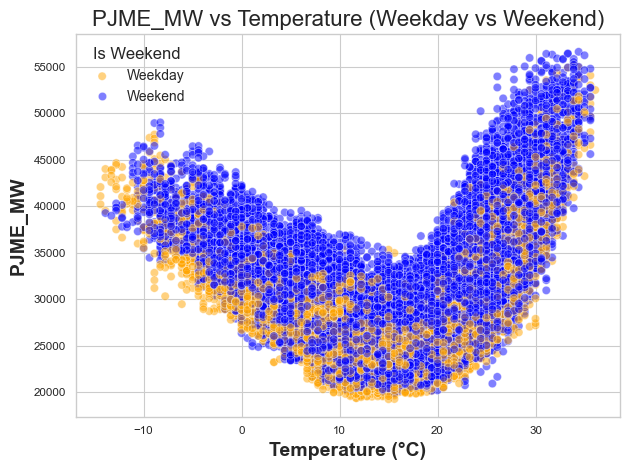

In [10]:

# Create the plot
sns.scatterplot(data=pjme_test, 
                x='temp', 
                y='PJME_MW', 
                hue='is_weekend',
                palette={False: 'blue', True: 'orange'},
                alpha=0.5)

# Customize the plot
plt.title('PJME_MW vs Temperature (Weekday vs Weekend)', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('PJME_MW', fontsize=14)

# Customize the legend
plt.legend(title='Is Weekend', labels=['Weekday', 'Weekend'], title_fontsize=12, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

X_train, y_train = pjme_train.drop(['PJME_MW', 'day_name'], axis=1), pjme_train['PJME_MW']
X_test, y_test = pjme_test.drop(['PJME_MW', 'day_name'], axis=1), pjme_test['PJME_MW']

In [12]:
X_train

,is_holiday,temp,is_weekend,hour,dayofweek,quarter,year,dayofyear,dayofmonth,month,weekofyear
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,False,5.0,False,1,1,4,2002,365,31,12,1
2002-12-31 02:00:00,False,4.4,False,2,1,4,2002,365,31,12,1
2002-12-31 03:00:00,False,5.0,False,3,1,4,2002,365,31,12,1
2002-12-31 04:00:00,False,5.0,False,4,1,4,2002,365,31,12,1
2002-12-31 05:00:00,False,5.6,False,5,1,4,2002,365,31,12,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-01-01 20:00:00,True,5.6,False,20,3,1,2015,1,1,1,1
2015-01-01 21:00:00,True,4.4,False,21,3,1,2015,1,1,1,1
2015-01-01 22:00:00,True,4.4,False,22,3,1,2015,1,1,1,1


In [13]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

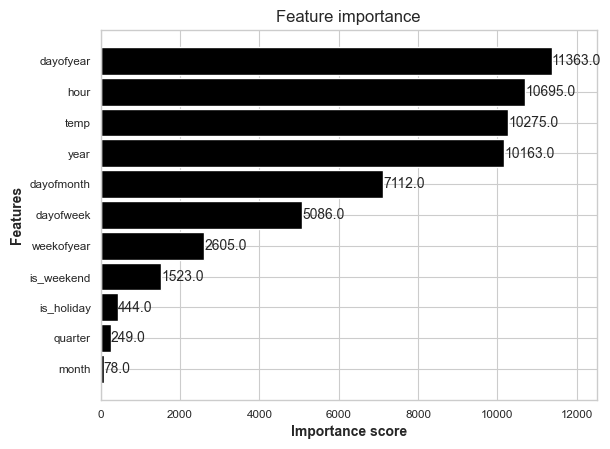

In [14]:
_ = plot_importance(reg, height=0.9)


<Axes: xlabel='Datetime'>

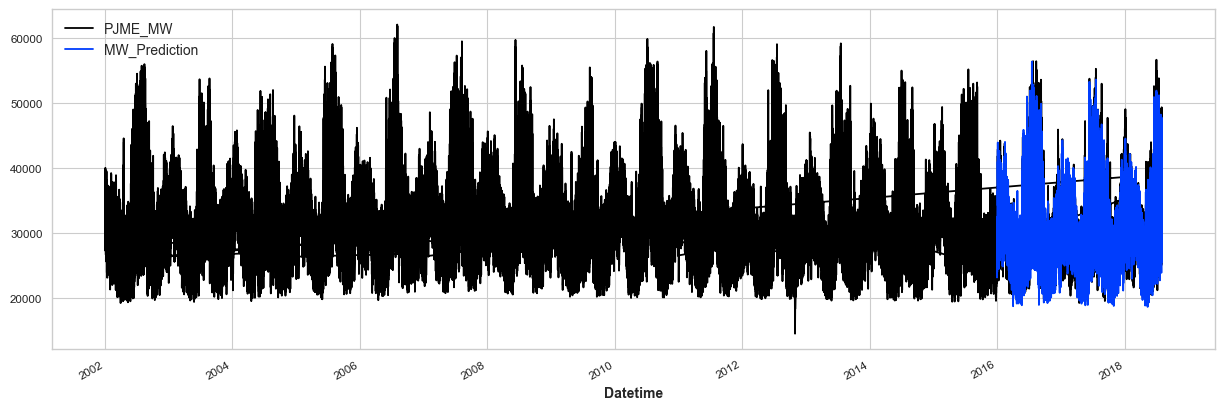

In [15]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))


Look at first month of predictions


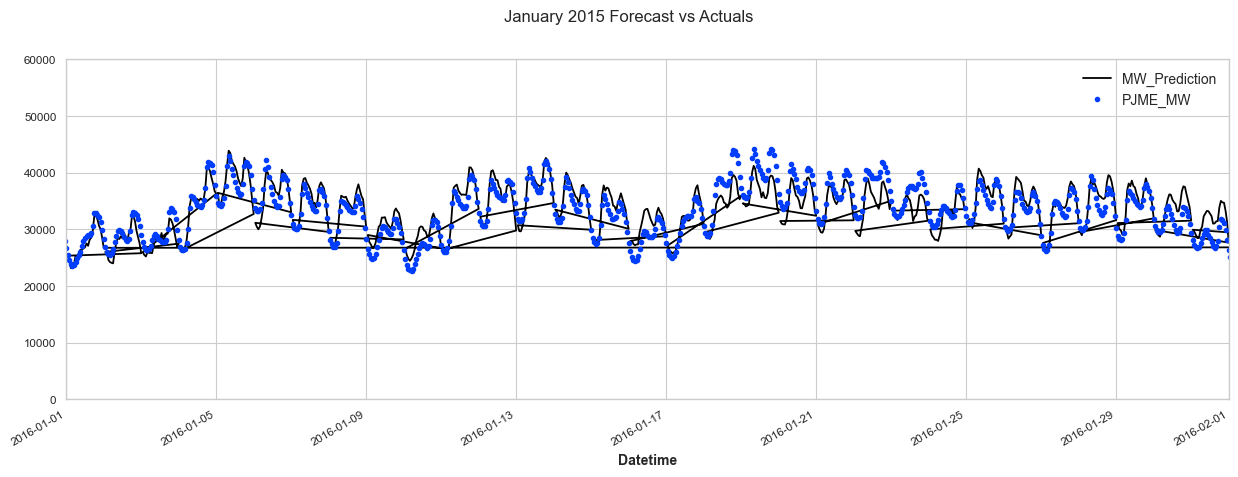

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2016', upper='02-01-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

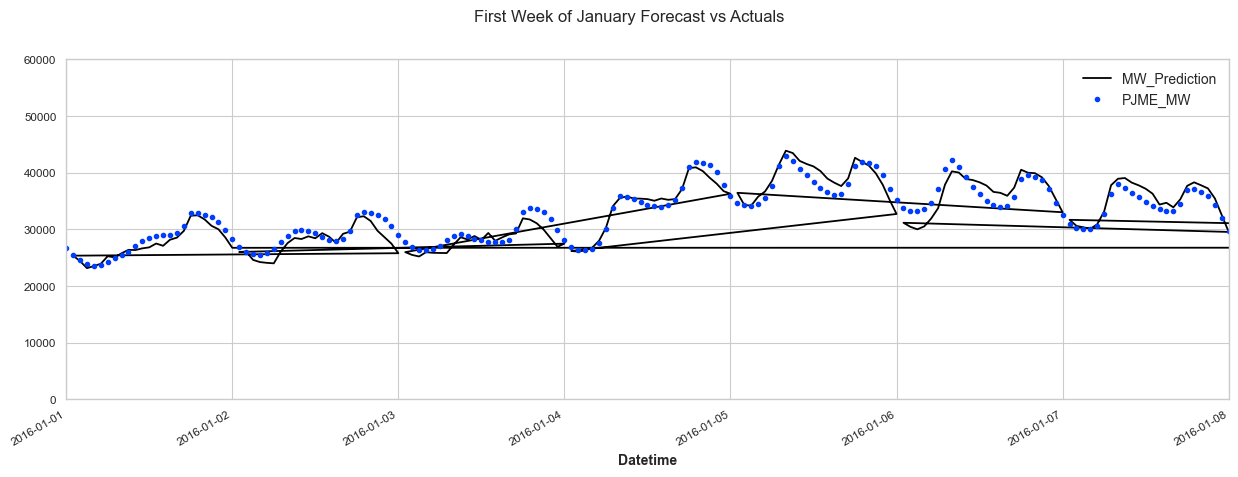

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2016', upper='01-08-2016')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mse = mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 5601608.645521252
Mean Absolute Error: 1763.6300285713105
Mean Absolute Percentage Error: 0.0552517278335809


In [19]:
pjme_test.dtypes

is_holiday          bool
temp             float64
is_weekend          bool
day_name          object
hour               int32
dayofweek          int32
quarter            int32
year               int32
dayofyear          int32
dayofmonth         int32
month              int32
weekofyear        UInt32
PJME_MW          float64
MW_Prediction    float32
dtype: object

In [33]:
pjme_test['abs_error'] = (pjme_test['PJME_MW'] - pjme_test['MW_Prediction'])\
                            .apply(np.abs)

error_by_day = pjme_test.groupby([pjme_test.index.year, 
                                    pjme_test.index.month, 
                                    pjme_test.index.day]) \
                        .agg({'PJME_MW': 'mean',
                            'MW_Prediction': 'mean',
                            'error': 'mean',
                            'abs_error': 'mean'})
error_by_day.index.names = ['year', 'month', 'dayofmonth']


In [34]:
error_by_day.sort_values('abs_error', ascending=True).head(10)


PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    25          27081.250000   27076.103516    5.145671  169.050456
2017 10    26          26713.458333   26664.197266   49.259766  232.964030
     11    4           24362.208333   24249.453125  112.755778  236.387288
2016 10    11          26699.833333   26783.939453  -84.106038  274.584880
           24          26255.000000   26257.880859   -2.880371  280.228841
     9     30          26981.708333   27113.296875 -131.588298  282.313395
     5     11          26756.208333   26598.375000  157.832194  290.037923
           15          23152.458333   23043.943359  108.516357  293.491130
     4     20          26191.541667   26039.085938  152.455322  302.931722
     10    7           27065.958333   27130.890625  -64.931966  305.224447

In [35]:
error_by_day.sort_values('abs_error', ascending=True).head(10)


PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    25          27081.250000   27076.103516    5.145671  169.050456
2017 10    26          26713.458333   26664.197266   49.259766  232.964030
     11    4           24362.208333   24249.453125  112.755778  236.387288
2016 10    11          26699.833333   26783.939453  -84.106038  274.584880
           24          26255.000000   26257.880859   -2.880371  280.228841
     9     30          26981.708333   27113.296875 -131.588298  282.313395
     5     11          26756.208333   26598.375000  157.832194  290.037923
           15          23152.458333   23043.943359  108.516357  293.491130
     4     20          26191.541667   26039.085938  152.455322  302.931722
     10    7           27065.958333   27130.890625  -64.931966  305.224447

In [55]:
def actual_predict_plotter(df: pd.DataFrame,
                            pred_var: str, 
                            y_var: str, 
                            title: str
                    ) -> None:
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df[pred_var], marker=None, label=pred_var, color=color_pal[3])
    sns.scatterplot(data=df[y_var], marker='.', label=y_var, color=color_pal[1])

    # Customize the plot
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(y_var)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

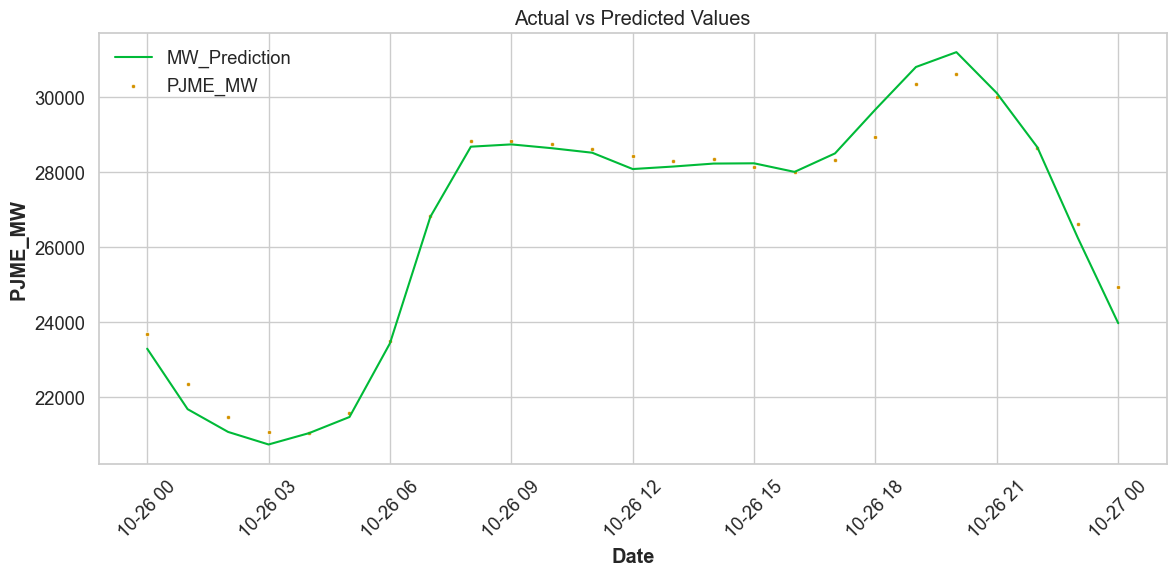

In [58]:

xx = pjme_all[['MW_Prediction','PJME_MW']] \
    .loc[(pjme_all.index >= datetime(2017, 10, 26))
        & (pjme_all.index <= datetime(2017, 10, 27))]

actual_predict_plotter(xx, 'MW_Prediction', 'PJME_MW', 'Actual vs Predicted Values')

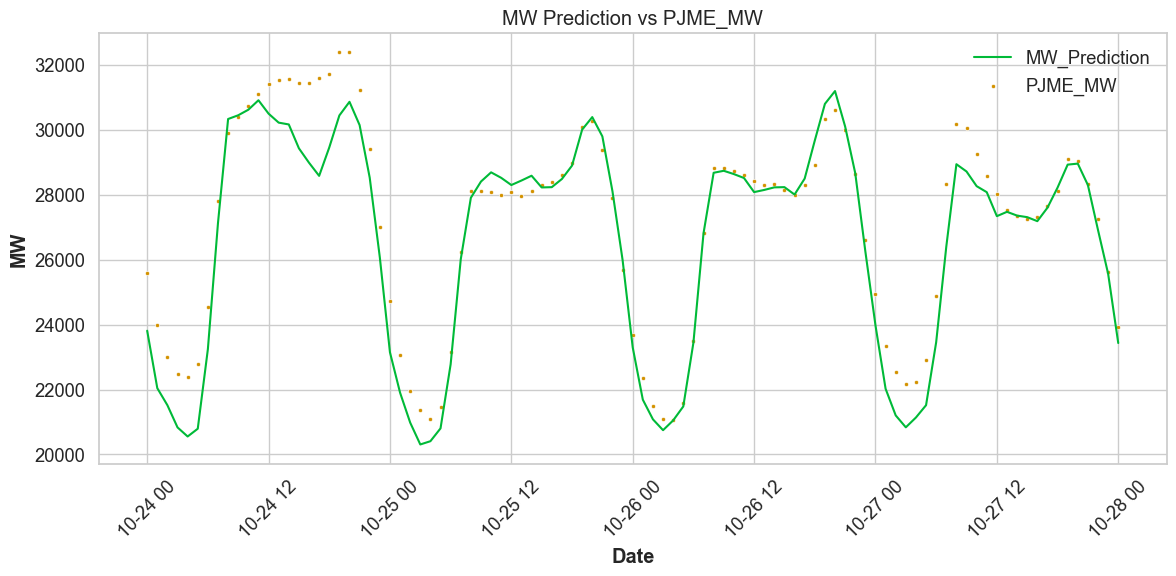

In [ ]:
filtered_data = pjme_all[['MW_Prediction','PJME_MW']]\
    .loc[(pjme_all.index >= datetime(2017, 10, 24)) 
        & (pjme_all.index <= datetime(2017, 10, 28))]\

